In [15]:
# Install necessary libraries
!pip install yfinance matplotlib pandas gym numpy seaborn

# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import gym
from gym import spaces
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set()  # Set seaborn style


[*********************100%***********************]  1 of 1 completed


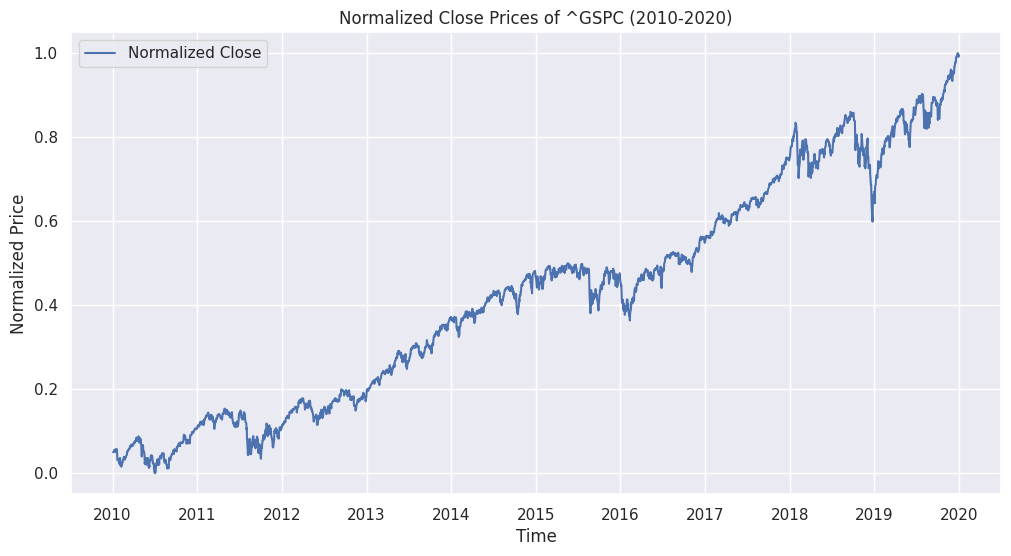

In [16]:
# Fetch historical stock price data
data = yf.download('^GSPC', start='2010-01-01', end='2020-01-01')

# Normalize closing prices
scaler = MinMaxScaler(feature_range=(0, 1))
data['Normalized_Close'] = scaler.fit_transform(data[['Close']])

# Visualize normalized data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Normalized_Close'], label='Normalized Close')
plt.title('Normalized Close Prices of ^GSPC (2010-2020)')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()


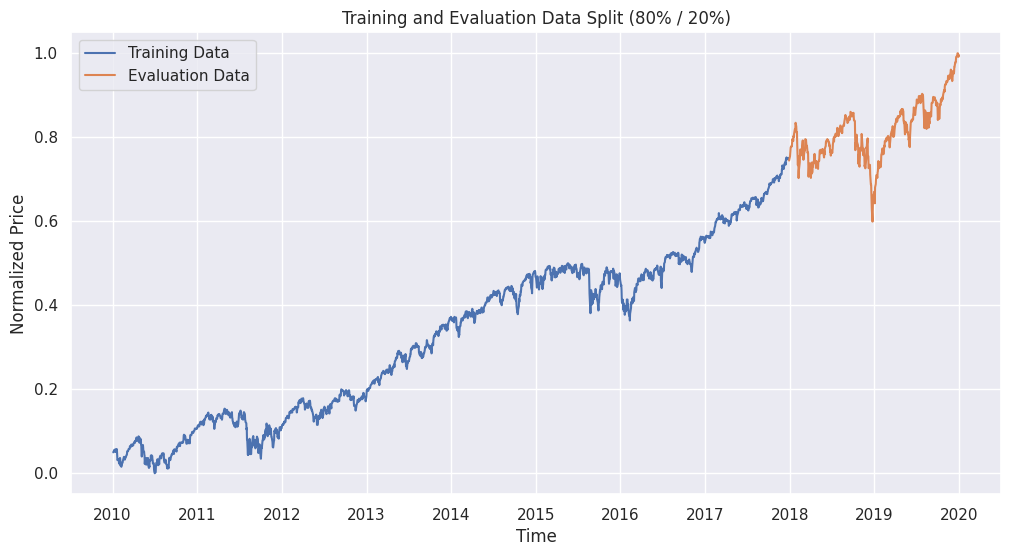

Training data size: 2012
Evaluation data size: 504


In [17]:
# Split data into training and evaluation sets
train_ratio = 0.8
train_size = int(len(data) * train_ratio)

training_data = data[:train_size]
evaluation_data = data[train_size:]

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(training_data.index, training_data['Normalized_Close'], label='Training Data')
plt.plot(evaluation_data.index, evaluation_data['Normalized_Close'], label='Evaluation Data')
plt.title('Training and Evaluation Data Split (80% / 20%)')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()
plt.show()

print(f"Training data size: {len(training_data)}")
print(f"Evaluation data size: {len(evaluation_data)}")


In [45]:
class TradingEnv(gym.Env):
    def __init__(self, data, window_size):
        super(TradingEnv, self).__init__()
        self.data = data
        self.window_size = window_size
        self.action_space = spaces.Discrete(3)  # Actions: Buy, Sell, Hold
        self.observation_space = spaces.Box(low=0, high=1, shape=(window_size,), dtype=np.float32)
        self.current_step = None
        self.inventory = []
        self.current_price = None

    def reset(self):
        self.current_step = self.window_size
        self.inventory = []
        # Extract scalar value explicitly
        self.current_price = self.data['Close'].iloc[self.current_step].item()
        return self._get_state()

    def step(self, action):
        # Extract scalar value explicitly
        self.current_price = self.data['Close'].iloc[self.current_step].item()
        reward = 0
        done = False

        if action == 0:  # Hold
            reward = 0
        elif action == 1:  # Buy
            self.inventory.append(self.current_price)
            reward = 0
        elif action == 2 and len(self.inventory) > 0:  # Sell
            bought_price = self.inventory.pop(0)
            reward = self.current_price - bought_price

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True

        return self._get_state(), reward, done, {}

    def _get_state(self):
        start = self.current_step - self.window_size
        state = self.data['Normalized_Close'].iloc[start:self.current_step].values
        return state


In [46]:
env = TradingEnv(data=training_data, window_size=10)
initial_state = env.reset()
print("Initial State:", initial_state)
print("Initial Current Price:", env.current_price)


Initial State: [0.04979164 0.05138358 0.05166318 0.05371506 0.05519877 0.05610071
 0.05124827 0.05551448 0.05676814 0.05116261]
Initial Current Price: 1150.22998046875


In [25]:
# Initialize the trading environment
window_size = 10  # Sliding window size for state
env = TradingEnv(data=training_data, window_size=window_size)

# Reset the environment to get the initial state
state = env.reset()
print("Initial State:", state)

# Take some random actions to test the environment
for _ in range(5):
    action = env.action_space.sample()  # Random action: 0=Hold, 1=Buy, 2=Sell
    next_state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward}, Done: {done}")
    if done:
        break


Initial State: [0.04979164 0.05138358 0.05166318 0.05371506 0.05519877 0.05610071
 0.05124827 0.05551448 0.05676814 0.05116261]
Action: 2, Reward: 0, Done: False
Action: 1, Reward: 0, Done: False
Action: 0, Reward: 0, Done: False
Action: 0, Reward: 0, Done: False
Action: 1, Reward: 0, Done: False


<ipython-input-24-8c9a76b249d0>:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  reward = float(current_price - bought_price)  # Ensure reward is scalar float


Episode 100/1000, Total Reward: 4946.56
Episode 200/1000, Total Reward: 3957.80
Episode 300/1000, Total Reward: 8774.21
Episode 400/1000, Total Reward: 56701.05
Episode 500/1000, Total Reward: 23713.97
Episode 600/1000, Total Reward: 11331.15
Episode 700/1000, Total Reward: 36846.15
Episode 800/1000, Total Reward: 112460.57
Episode 900/1000, Total Reward: 8812.48
Episode 1000/1000, Total Reward: 113616.76


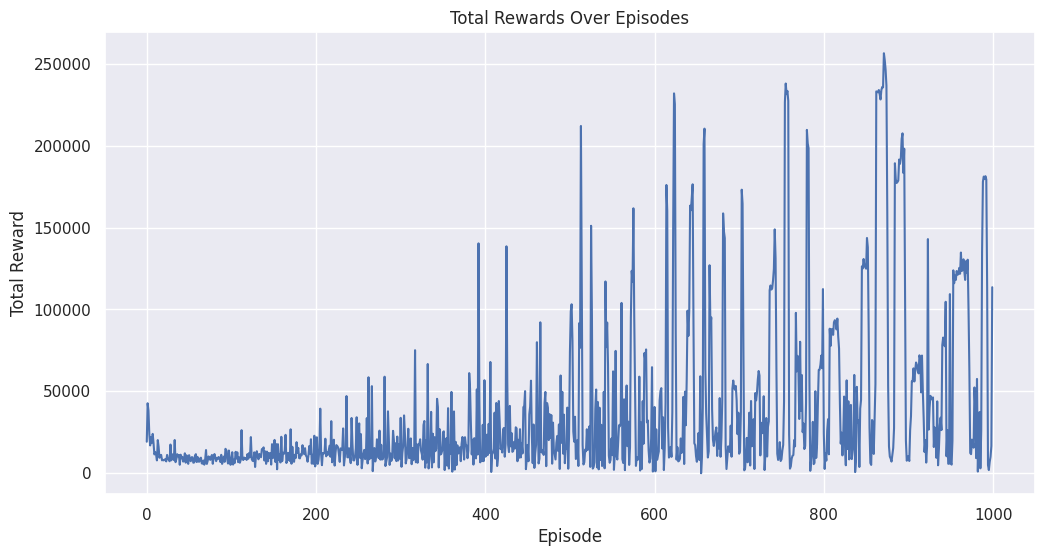

In [26]:
# Q-Learning Parameters
alpha = 0.1  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 1.0  # Initial exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Epsilon decay for exploration-exploitation balance
episodes = 1000  # Number of training episodes

# Initialize Q-Table (discretized states and actions)
state_size = env.observation_space.shape[0]  # State size (window size)
action_size = env.action_space.n  # Number of actions (Buy, Sell, Hold)
q_table = np.zeros((state_size, action_size))

# Training loop
rewards = []
for episode in range(episodes):
    state = env.reset()  # Reset environment at the start of each episode
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() <= epsilon:
            action = env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(q_table[state.argmax()])  # Exploit: best action

        # Take action and observe reward
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Update Q-Table using the Bellman equation
        q_table[state.argmax(), action] = (1 - alpha) * q_table[state.argmax(), action] + \
                                          alpha * (reward + gamma * np.max(q_table[next_state.argmax()]))

        # Transition to next state
        state = next_state

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}")

# Save the Q-Table for future use
np.save("q_table.npy", q_table)

# Plot the total rewards over episodes
plt.figure(figsize=(12, 6))
plt.plot(rewards)
plt.title("Total Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()


Total Reward during Evaluation: 107988.28186035156


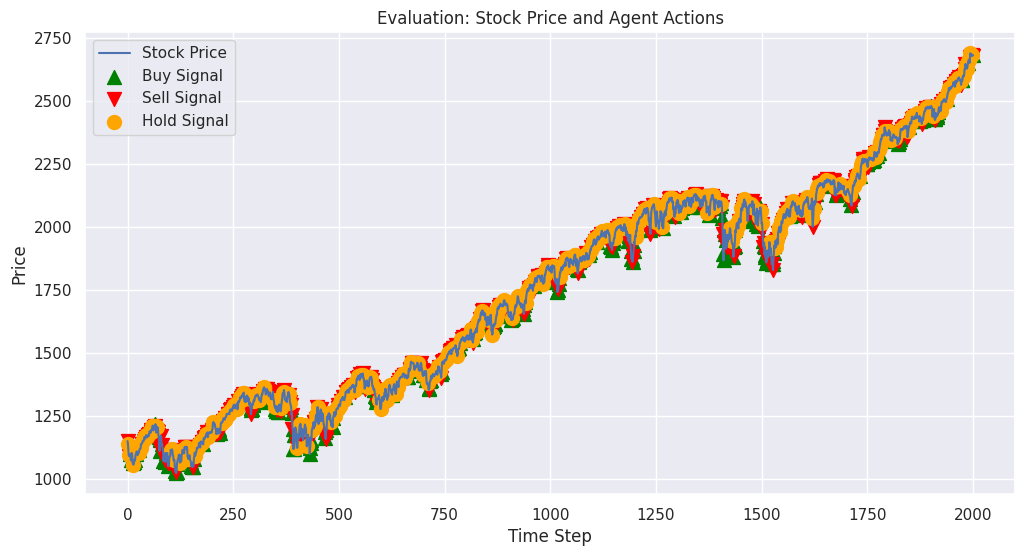

In [47]:
# Evaluate the trained agent on the evaluation dataset
state = env.reset()  # Reset environment
total_reward = 0
done = False

# Lists to store actions and prices for visualization
actions = []
prices = []

while not done:
    # Use the trained Q-Table for action selection
    action = np.argmax(q_table[state.argmax()])
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    # Record action and price for visualization
    actions.append(action)
    prices.append(env.current_price)  # Store current price
    state = next_state

print(f"Total Reward during Evaluation: {total_reward}")

# Plot the evaluation results
plt.figure(figsize=(12, 6))
plt.plot(prices, label="Stock Price")
buy_signals = [i for i, a in enumerate(actions) if a == 0]
sell_signals = [i for i, a in enumerate(actions) if a == 1]
hold_signals = [i for i, a in enumerate(actions) if a == 2]
plt.scatter(buy_signals, [prices[i] for i in buy_signals], color="green", label="Buy Signal", marker="^", s=100)
plt.scatter(sell_signals, [prices[i] for i in sell_signals], color="red", label="Sell Signal", marker="v", s=100)
plt.scatter(hold_signals, [prices[i] for i in hold_signals], color="orange", label="Hold Signal", marker="o", s=100)
plt.title("Evaluation: Stock Price and Agent Actions")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()


In [48]:
import gym
from gym import spaces

class TradingEnv(gym.Env):
    def __init__(self, data, window_size):
        super(TradingEnv, self).__init__()
        self.data = data
        self.window_size = window_size
        self.current_step = self.window_size

        # Define action and observation space
        self.action_space = spaces.Discrete(3)  # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(self.window_size,), dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.current_step = self.window_size
        self.inventory = []
        self.total_reward = 0.0
        self.done = False
        self.current_price = float(self.data['Close'].iloc[self.current_step])
        state = self.data['Normalized_Close'].iloc[
            self.current_step - self.window_size : self.current_step
        ].values
        return state

    def step(self, action):
        # Perform the action
        reward = 0.0
        current_price = float(self.data['Close'].iloc[self.current_step])
        if action == 1:  # Buy
            self.inventory.append(current_price)
        elif action == 2 and self.inventory:  # Sell
            bought_price = self.inventory.pop(0)
            reward = current_price - bought_price
            self.total_reward += reward
        elif action == 2:  # Sell without inventory
            reward = -10  # Penalize invalid Sell
        else:  # Hold
            reward = 0.0

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.data)

        # Prepare next state
        if not done:
            next_state = self.data['Normalized_Close'].iloc[
                self.current_step - self.window_size : self.current_step
            ].values
        else:
            next_state = np.zeros(self.window_size)

        return next_state, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Total Reward: {self.total_reward}")


In [49]:
# Initialize the new environment
env = TradingEnv(data=training_data, window_size=10)

# Reset the environment
initial_state = env.reset()

# Display the initial state and price
print("Initial State:", initial_state)
print("Initial Current Price:", env.current_price)

# Perform some random actions for debugging
for _ in range(5):  # Test 5 steps
    action = env.action_space.sample()  # Random action
    state, reward, done, _ = env.step(action)
    print(f"Action: {action}, Reward: {reward}, Done: {done}")
    if done:
        break


Initial State: [0.04979164 0.05138358 0.05166318 0.05371506 0.05519877 0.05610071
 0.05124827 0.05551448 0.05676814 0.05116261]
Initial Current Price: 1150.22998046875
Action: 0, Reward: 0.0, Done: False
Action: 1, Reward: 0.0, Done: False
Action: 2, Reward: -21.56005859375, Done: False
Action: 2, Reward: -10, Done: False
Action: 2, Reward: -10, Done: False


<ipython-input-48-6cbef041394c>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.current_price = float(self.data['Close'].iloc[self.current_step])
<ipython-input-48-6cbef041394c>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.data['Close'].iloc[self.current_step])


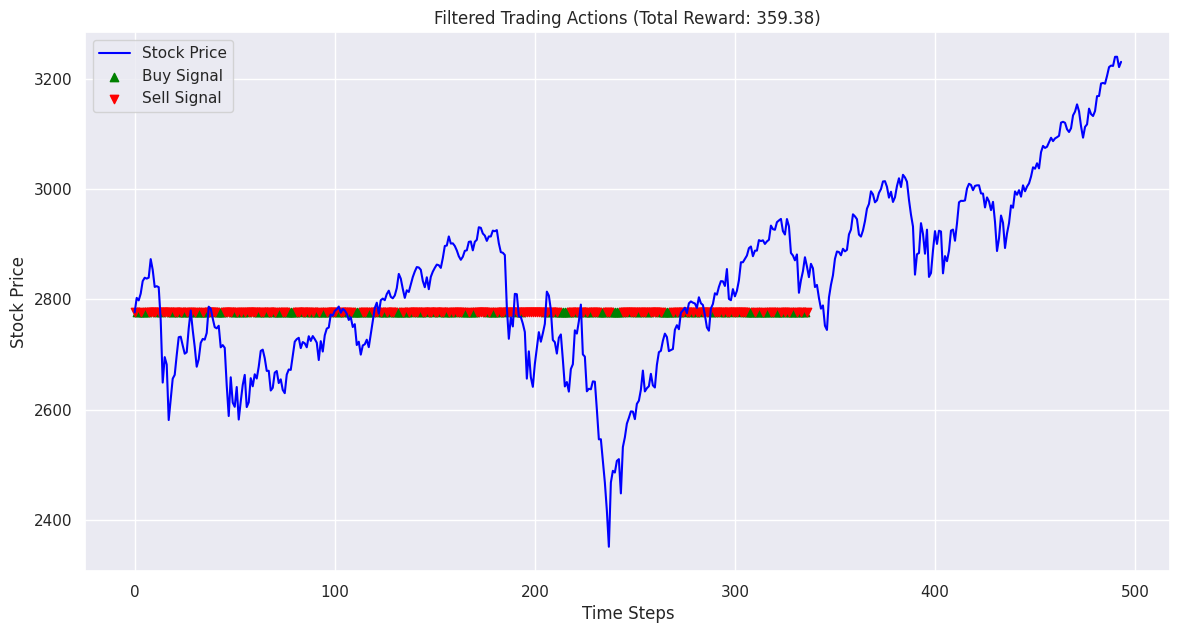

In [53]:
# Filter significant actions for clearer visualization
reward_threshold = 10  # Only actions with significant rewards
filtered_buy_signals = [i for i, action in enumerate(actions) if action == 1 and rewards[i] > reward_threshold]
filtered_sell_signals = [i for i, action in enumerate(actions) if action == 2 and rewards[i] > reward_threshold]

# Plotting the filtered graph
plt.figure(figsize=(14, 7))
plt.plot(evaluation_data['Close'].iloc[10:].values, label="Stock Price", color='blue')
plt.scatter(filtered_buy_signals, [prices[i] for i in filtered_buy_signals], label="Buy Signal", color='green', marker='^')
plt.scatter(filtered_sell_signals, [prices[i] for i in filtered_sell_signals], label="Sell Signal", color='red', marker='v')
plt.title(f"Filtered Trading Actions (Total Reward: {total_reward:.2f})")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Load the pre-trained Q-Table
q_table = np.load("q_table.npy")
print("Q-Table successfully loaded.")



Q-Table successfully loaded.


/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


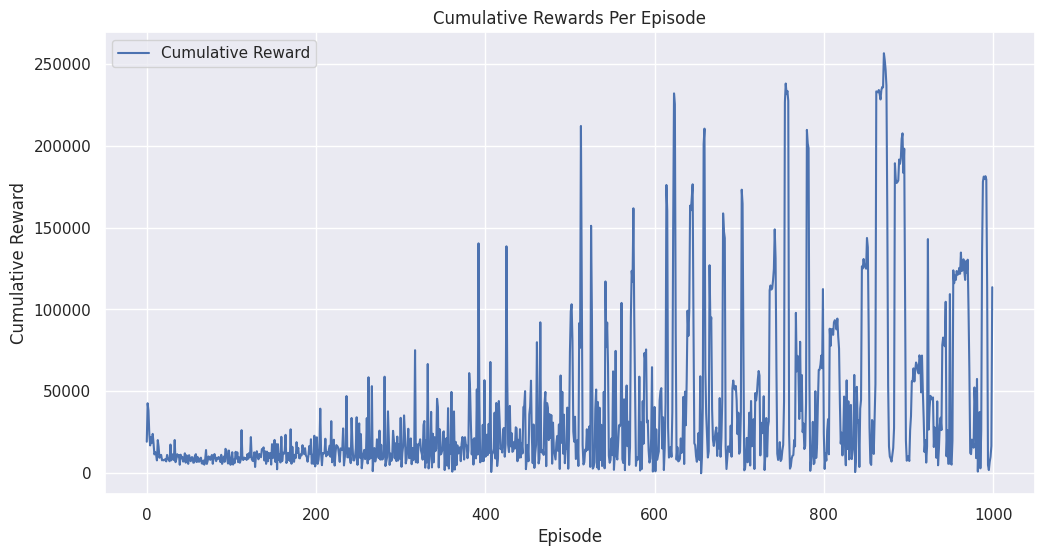

In [65]:
# Assuming you have the `rewards` list from training
plt.figure(figsize=(12, 6))
plt.plot(range(len(rewards)), rewards, label="Cumulative Reward")
plt.title("Cumulative Rewards Per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()



<ipython-input-48-6cbef041394c>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.current_price = float(self.data['Close'].iloc[self.current_step])
<ipython-input-48-6cbef041394c>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.data['Close'].iloc[self.current_step])


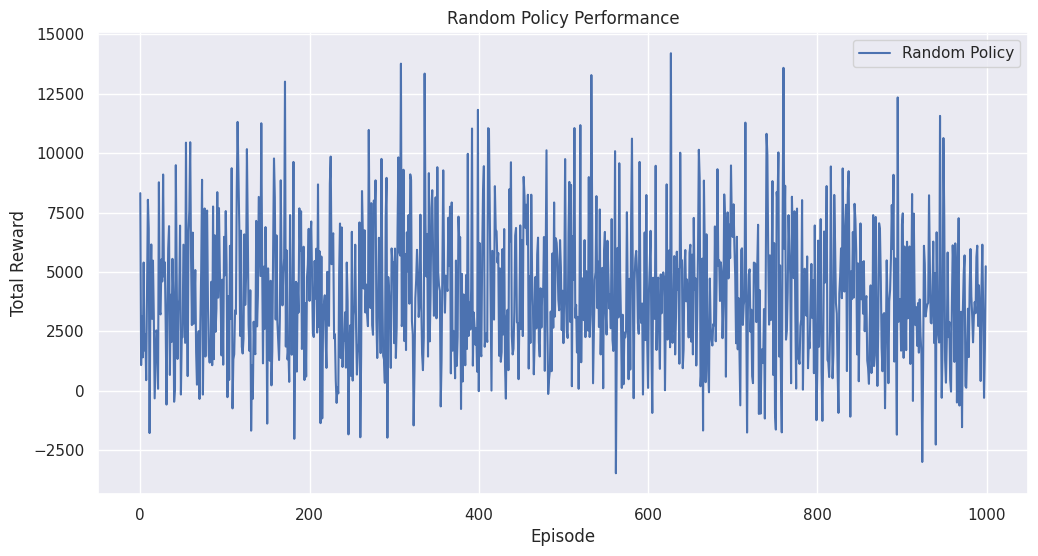

In [68]:
# Evaluate random policy
random_rewards = []
for _ in range(len(rewards)):
    random_total_reward = 0
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        _, reward, done, _ = env.step(action)
        random_total_reward += reward
    random_rewards.append(random_total_reward)

# Plot random policy rewards
plt.figure(figsize=(12, 6))
plt.plot(range(len(random_rewards)), random_rewards, label="Random Policy")
plt.title("Random Policy Performance")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


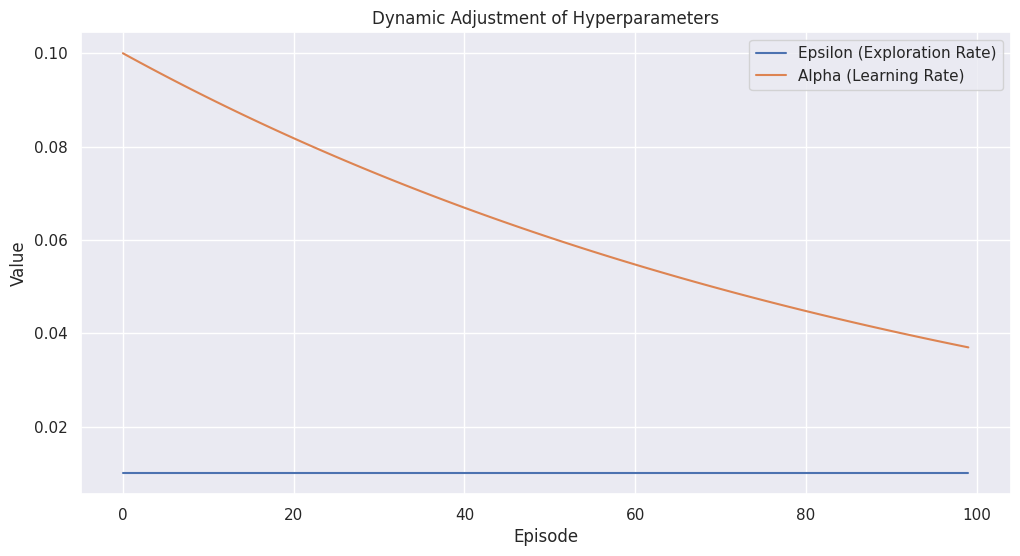

In [70]:
# Plot Decay of Learning Rate and Epsilon
alpha_values = [alpha * (0.99 ** i) for i in range(episodes)]  # Example decay
plt.figure(figsize=(12, 6))
plt.plot(range(len(epsilon_values)), epsilon_values, label="Epsilon (Exploration Rate)")
plt.plot(range(len(alpha_values)), alpha_values, label="Alpha (Learning Rate)")
plt.title("Dynamic Adjustment of Hyperparameters")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()


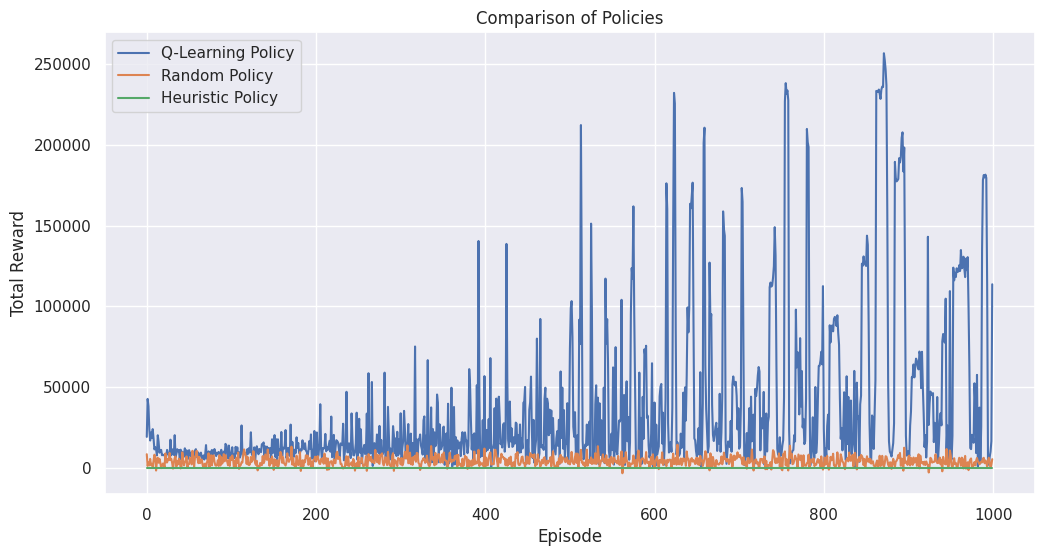

In [71]:
# Comparison of Total Rewards
plt.figure(figsize=(12, 6))
plt.plot(range(len(rewards)), rewards, label="Q-Learning Policy")
plt.plot(range(len(random_rewards)), random_rewards, label="Random Policy")
plt.plot(range(len(heuristic_rewards)), heuristic_rewards, label="Heuristic Policy")
plt.title("Comparison of Policies")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


In [79]:
# Initialize a list to store Q-tables over episodes
q_table_over_episodes = []

# Training loop (already implemented logic)
for episode in range(episodes):
    # Existing training logic

    # Save the Q-table at the end of each episode
    q_table_over_episodes.append(q_table.copy())  # Use .copy() to save a snapshot


In [81]:
print(f"Number of saved Q-tables: {len(q_table_over_episodes)}")


Number of saved Q-tables: 100


In [82]:
print(f"Shape of a Q-table: {q_table_over_episodes[0].shape}")


Shape of a Q-table: (10, 3)


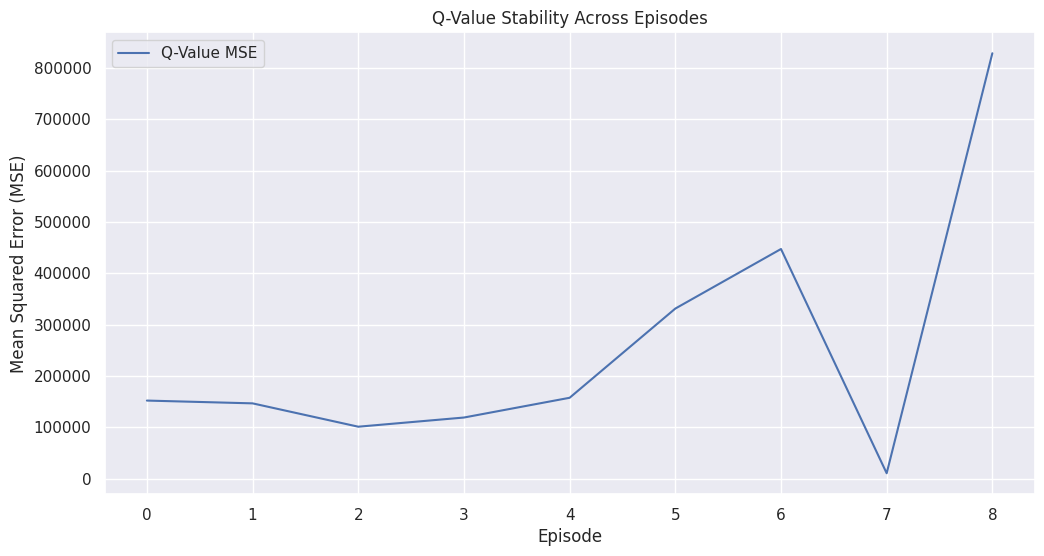

In [83]:
# Load saved q_table_over_episodes (if saved as a .npy file)
q_table_over_episodes = np.load("q_table.npy", allow_pickle=True)

# Continue with MSE calculation and plotting
mse_values = []
if len(q_table_over_episodes) > 1:
    for episode in range(len(q_table_over_episodes) - 1):
        mse = np.mean((q_table_over_episodes[episode] - q_table_over_episodes[episode + 1]) ** 2)
        mse_values.append(mse)

# Plot Q-Value Stability
plt.figure(figsize=(12, 6))
plt.plot(range(len(mse_values)), mse_values, label="Q-Value MSE")
plt.title("Q-Value Stability Across Episodes")
plt.xlabel("Episode")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()


<ipython-input-48-6cbef041394c>:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self.current_price = float(self.data['Close'].iloc[self.current_step])
<ipython-input-48-6cbef041394c>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(self.data['Close'].iloc[self.current_step])


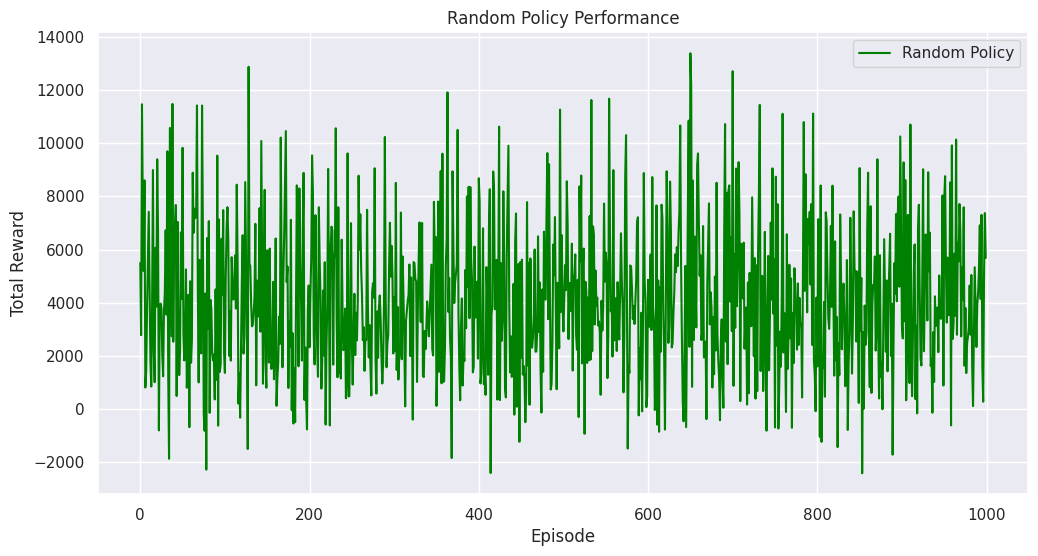

In [86]:
random_rewards = []
for episode in range(1000):  # Same number of episodes as training
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()  # Random action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state
    random_rewards.append(total_reward)

# Plot random policy rewards
plt.figure(figsize=(12, 6))
plt.plot(range(len(random_rewards)), random_rewards, label="Random Policy", color='green')
plt.title("Random Policy Performance")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()
